In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

plt.style.use('../../figure_style.mplstyle')

# Load data
data = loadmat('../data/cylinder_nektar_wake.mat')

U_star = data['U_star']
P_star = data['p_star']
t_star = data['t']
x_star = data['X_star']
print(x_star.shape, t_star.shape, U_star.shape, P_star.shape)

N = x_star.shape[0]
T = t_star.shape[0]

# Reshape data 
XX = np.tile(x_star[:,0:1], (1,T)) # N x T
YY = np.tile(x_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(5000, 2) (200, 1) (5000, 2, 200) (5000, 200)


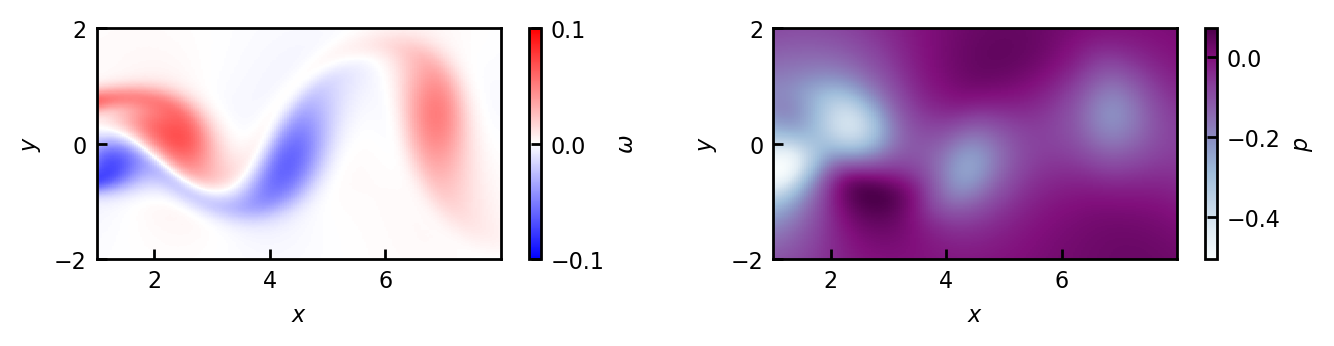

In [32]:
from scipy.interpolate import griddata

nn = 200
lb = x_star.min(0)
ub = x_star.max(0)
X, Y = np.meshgrid(
    np.linspace(lb[0], ub[0], nn),
    np.linspace(lb[1], ub[1], nn)
)

def plot_field(ax, u, v, p, vmin=-0.1, vmax=0.1, pmin=None, pmax=None):
    assert len(ax) == 2

    # Plot vorticity
    u_grid = griddata(x_star, u, (X, Y), method='cubic')
    v_grid = griddata(x_star, v, (X, Y), method='cubic')
    vort = np.gradient(u_grid, axis=0) - np.gradient(v_grid, axis=1)
    im = ax[0].pcolormesh(X, Y, vort, cmap='bwr', vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax[0], label='$\\omega$', ticks=[-0.1, 0, 0.1])

    # Plot pressure
    p_grid = griddata(x_star, p, (X, Y), method='cubic')
    im = ax[1].pcolormesh(X, Y, p_grid, cmap='BuPu', vmin=pmin, vmax=pmax)
    plt.colorbar(im, ax=ax[1], label='$p$')

    for a in ax:
        a.set(
            xlabel='$x$', xlim=[1, 8], xticks=[2, 4, 6],
            ylabel='$y$', ylim=[-2, 2], yticks=[-2, 0, 2],
            aspect='equal',
        )
    
fig, ax = plt.subplots(1, 2, figsize=(8, 1.5))
plot_field(ax, U_star[:, 0, 0], U_star[:, 1, 0], P_star[:, 0])

In [36]:
import torch
from navier_stokes_pinn import NavierStokesParameterPINN

# Training Data    
N_u = 20000
idx = np.random.choice(N*T, N_u, replace=False)
x_f = x[idx,:]
y_f = y[idx,:]
t_f = t[idx,:]
u_f = u[idx,:]
v_f = v[idx,:]


if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Starting to train on device {device}')

model = NavierStokesParameterPINN(
    data=dict(
        x_f=x_f,
        y_f=y_f,
        t_f=t_f,
        u_f=u_f,
        v_f=v_f,
    ),
    log_dir="./tb_logs/Navier_Stokes"
).to(device)
model.train(1)

Starting to train on device cuda:0
Iteration 1000, Loss: 1.01570e-01, MSE: 1.01502e-01, Phys: 6.81777e-05
Iteration 2000, Loss: 1.00797e-01, MSE: 1.00731e-01, Phys: 6.62893e-05
Iteration 3000, Loss: 1.00122e-01, MSE: 1.00030e-01, Phys: 9.24163e-05
Iteration 4000, Loss: 9.94674e-02, MSE: 9.93171e-02, Phys: 1.50322e-04


KeyboardInterrupt: 